In [1]:
!pip install keras


In [2]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [20]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout,Reshape, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D,Conv2DTranspose,Concatenate, ConvLSTM2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [4]:
def conv_block(x, n_base, batch_normalization):
    
    x = Conv2D(filters=n_base, kernel_size=(3,3), 
                        strides=(1,1),padding='same')(x)
    if (batch_normalization):
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=n_base, kernel_size=(3,3), 
                        strides=(1,1),padding='same')(x)
    if (batch_normalization):
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [5]:
def downsample_block(x, n_base, batch_normalization, dropout):
    f = conv_block(x, n_base, batch_normalization)
    p = layers.MaxPool2D(pool_size = (2,2))(f)
    if(dropout):
        p = layers.Dropout(0.2)(p)
        
    return f, p

In [41]:
# Add ConvLSTM2D layers

def upsample_block(x, f, n_base, batch_normalization, dropout, img_w):
    # 30x30x64 -> (1,30,30,64)
    x = Conv2DTranspose(filters=n_base, kernel_size=(2,2), 
                         strides=(2,2),padding='same')(x)
    # Reshape
    x2 = Reshape(target_shape=(1, x.shape[0], x.shape[0], n_base))(x)
    x1 = Reshape(target_shape=(1, x.shape[0], x.shape[0], n_base))(f)

    # Concatenate
    x = Concatenate([x1, x2], axis=1)

    # x = Dropout(0.5)(x)

    #LSTM
    x = ConvLSTM2D(np.int32(n_base/2), (3, 3), padding='same', return_sequences=False, go_backwards=True)(x)

    if(dropout):
        x = layers.Dropout(0.2)(x)
    
    # the function conv2d_block implements the usual convolutional block with 2 convolutional layer:
    # conv6 = conv2d_block(x, n_filters=n_base * 8, kernel_size=3, batchnorm= True)
    x = conv_block(x, n_base, batch_normalization)
        
    return x

In [42]:
def get_unet_weightmap(img_w, img_h, img_ch, n_base, LR, batch_normalization, dropout):
    
    ## Encoder part
    model = Sequential()
    image = layers.Input((img_w, img_h, img_ch))
    weight = layers.Input((img_w, img_h, img_ch))

    # p1
    inputs= layers.concatenate([image,weight],axis=-1)

    # inputs = layers.Input((img_w, img_h, img_ch))
    
    f1, p2 = downsample_block(inputs, n_base, batch_normalization, dropout)
    f2, p3 = downsample_block(p2, n_base*2, batch_normalization, dropout)
    f3, p4 = downsample_block(p3, n_base*4, batch_normalization, dropout)
    f4, p5 = downsample_block(p4, n_base*8, batch_normalization, dropout)
    
    
    ## Bottleneck
    bottleneck = conv_block(p5, n_base*16, batch_normalization)
    
    ## Decoder part
    p6 = upsample_block(bottleneck, f4, n_base*8, batch_normalization, dropout, img_w)
    p7 = upsample_block(p6, f3, n_base*4, batch_normalization, dropout, img_w)
    p8 = upsample_block(p7, f2, n_base*2, batch_normalization, dropout, img_w)
    p9 = upsample_block(p8, f1, n_base, batch_normalization, dropout, img_w)

    
    ## 1 Convo layer
    p9 = Conv2D(filters=1, kernel_size=(1,1), 
                            padding='same')(p8)
    outputs = Activation('sigmoid')(p9)
    

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    
    return model


In [9]:
## Task1a) Lung segmentation in chest X-ray images:
import os
from random import shuffle
from skimage.io import imread
from skimage.transform import resize


image_path = '/DL_course_data/Lab3/MRI/Image' 
mask_path = '/DL_course_data/Lab3/MRI/Mask'



In [10]:
from scipy.ndimage import binary_dilation, binary_erosion

def load_data(image_path,mask_path):
    
    image_list = os.listdir(image_path)
    mask_list = os.listdir(mask_path)
    
    images = []
    masks = []

    for image in image_list:
        img = imread(os.path.join(image_path, image), as_gray=True)  # "as_grey"
        img = resize(img, (240, 240), anti_aliasing=True).astype('float32')
        images.append(img)

    for image in image_list:
        mask_img = imread(os.path.join(mask_path, str.replace(image,'.png','_Tumor.png')), as_gray=True)
        mask_img = resize(mask_img, (240, 240), anti_aliasing=True).astype('float32')
        masks.append(mask_img)


    images = np.expand_dims(images, axis = -1)
    masks = np.expand_dims(masks, axis = -1)
    
    return np.array(images), np.array(masks)
    

In [11]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [12]:
n_base =8
LR = 1e-4
batch_normalization = True
dropout = True
epochs = 100
batch_size = 8
weight_strength = 1

img_w, img_h = 240,240
img_ch = 1

In [13]:
images, masks = load_data(image_path,mask_path)

In [14]:
from numpy import uint8
masks = masks.astype(uint8)

In [15]:
weight_boundary = np.zeros(masks.shape).astype(uint8)
for i in range(len(masks)):
    weight_boundary[i,:,:,0] = binary_dilation(masks[i,:,:,0], np.ones((5,5))).astype(int) - binary_erosion(masks[i,:,:,0],np.ones((5,5))).astype(int)

In [16]:
def weighted_loss(weight_map, weight_strength): 
    def weighted_dice_loss(y_true, y_pred):
        y_true_f = K.flatten(y_true) 
        y_pred_f = K.flatten(y_pred)
        weight_f = K.flatten(weight_map) 
        weight_f = weight_f * weight_strength 
        weight_f = 1/(weight_f + 1)
        weighted_intersection = K.sum(weight_f * (y_true_f * y_pred_f))
        return -(2. * weighted_intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    return weighted_dice_loss

In [43]:
model = get_unet_weightmap(img_w, img_h, img_ch, n_base, LR, 
                batch_normalization, dropout)

# Compile the model
model.compile(loss = [dice_coef_loss],          # Model Compiling   
            optimizer = Adam(lr = LR),
            metrics = [dice_coef, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

ValueError: Exception encountered when calling layer "reshape_21" (type Reshape).

Tried to convert 'shape' to a tensor and failed. Error: None values not supported.

Call arguments received by layer "reshape_21" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 30, 30, 64), dtype=float32)

In [37]:
a = 60*60*32
b = np.sqrt(a / 32)
b

60.0

In [17]:
tf.keras.backend.clear_session()

In [21]:
from numpy import concatenate

def generator_with_weights(x_train, y_train, weight_train, batch_size):
    while True:
               
        for ind in (range(0, len(x_train), batch_size)):
            
            batch_img = x_train[ind:ind+batch_size]
            batch_weightmap = weight_train[ind:ind+batch_size]
            batch_label = y_train[ind:ind+batch_size]
            
            # Sanity check assures batch size always satisfied
            # by repeating the last 2-3 images at last batch.
            if len(batch_img) == batch_size:
                pass
            else:
                for tmp in range(batch_size - len(batch_img)):
                    batch_img = np.append(batch_img, np.expand_dims(batch_img[-1],axis=0), axis = 0)
                    batch_weightmap = np.append(batch_weightmap, np.expand_dims(batch_weightmap[-1],axis=0), axis = 0)
                    batch_label = np.append(batch_label, np.expand_dims(batch_label[-1], axis=0), axis = 0)
        
            backgound_value = x_train.min()
            data_gen_args = dict(rotation_range=10.,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     cval = backgound_value,
                                     zoom_range=0.2,
                                     horizontal_flip = True)
            
            image_datagen = ImageDataGenerator(**data_gen_args)
            weights_datagen = ImageDataGenerator(**data_gen_args)
            mask_datagen = ImageDataGenerator(**data_gen_args)
            
            image_generator = image_datagen.flow(batch_img, shuffle=False,
                                                 batch_size=batch_size,
                                                 seed=1)

            weights_generator = image_datagen.flow(batch_weightmap, shuffle=False,
                                                 batch_size=batch_size,
                                                 seed=1)
            
            mask_generator = mask_datagen.flow(batch_label, shuffle=False,
                                               batch_size=batch_size,
                                               seed=1)
            
            image = image_generator.next()
            weight = weights_generator.next()
            label = mask_generator.next()
            input = concatenate([image,weight],axis=-1)
            
            
            yield input, label
            # yield (image, label)

In [22]:
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit

ShuffleSplit(n_splits=1, test_size=0.2).get_n_splits(images, masks)
train, val = next(ShuffleSplit(n_splits=1, test_size=0.2).split(images, masks)) 

In [23]:
tf.keras.backend.clear_session()
model = get_unet_weightmap(img_w, img_h, img_ch, n_base, LR, 
            batch_normalization, dropout)
model.compile(loss = [dice_coef_loss],          # Model Compiling   
            optimizer = Adam(lr = LR),
            metrics = [dice_coef, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# generator_with_weights(images[train], masks[train], weight_boundary[train], batch_size)
# generator_with_weights(images[val], masks[val], weight_boundary[val], batch_size)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 240, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 8)  152         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 8)  32         ['conv2d[1][0]']                 
 alization)                                                                                       
                                                                                              

In [24]:
model_history = model.fit_generator(generator_with_weights(images[train], masks[train], weight_boundary[train], batch_size),
    steps_per_epoch = len(images[train])//batch_size,
    validation_data = generator_with_weights(images[val], masks[val], weight_boundary[val], batch_size), 
    validation_steps = len(images[val])//batch_size,
    epochs = epochs,  verbose=1)

<ipython-input-24-e7f5ec89a0b0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(generator_with_weights(images[train], masks[train], weight_boundary[train], batch_size),


Epoch 1/100
940/940 [==============================] - 216s 226ms/step - loss: 0.9039 - dice_coef: 0.0961 - precision: 0.2892 - recall: 0.9886 - val_loss: 0.7614 - val_dice_coef: 0.2386 - val_precision: 0.7887 - val_recall: 0.9972
Epoch 2/100
940/940 [==============================] - 211s 225ms/step - loss: 0.7806 - dice_coef: 0.2194 - precision: 0.8509 - recall: 0.9915 - val_loss: 0.6845 - val_dice_coef: 0.3155 - val_precision: 0.9281 - val_recall: 0.9808
Epoch 3/100
940/940 [==============================] - 211s 225ms/step - loss: 0.5686 - dice_coef: 0.4314 - precision: 0.9292 - recall: 0.9695 - val_loss: 0.4238 - val_dice_coef: 0.5762 - val_precision: 0.9536 - val_recall: 0.9490
Epoch 4/100
940/940 [==============================] - 211s 225ms/step - loss: 0.3449 - dice_coef: 0.6551 - precision: 0.9542 - recall: 0.9447 - val_loss: 0.2363 - val_dice_coef: 0.7637 - val_precision: 0.9816 - val_recall: 0.9135
Epoch 5/100
940/940 [==============================] - 211s 225ms/step - los

In [ ]:
def show_hist(History): 
    plt.figure(figsize=(3, 3))
    plt.title("Learning curve")
    plt.plot(History.history["loss"], label="loss")
    plt.plot(History.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(History.history["val_loss"]),
            np.min(History.history["val_loss"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.show()

    plt.figure

    plt.figure(figsize=(3, 3))
    plt.title("dice_coef")
    plt.plot(History.history["dice_coef"], label="dice_coef")
    plt.plot(History.history["val_dice_coef"], label="val_dice_coef")
    plt.plot( np.argmax(History.history["val_dice_coef"]),
            np.max(History.history["val_dice_coef"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("dice_coef")
    plt.legend()
    plt.show()

    plt.figure

    plt.figure(figsize=(3, 3))
    plt.title("Precision")
    plt.plot(History.history["precision"], label="Precision")
    plt.plot(History.history["val_precision"], label="val_Precision")
    plt.plot( np.argmax(History.history["val_precision"]),
            np.max(History.history["val_precision"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    plt.figure

    plt.figure(figsize=(3, 3))
    plt.title("recall")
    plt.plot(History.history["recall"], label="recall")
    plt.plot(History.history["val_recall"], label="val_recall")
    plt.plot( np.argmax(History.history["val_recall"]),
            np.max(History.history["val_recall"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("recall")
    plt.legend()
    plt.show()

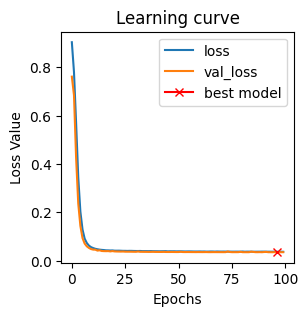

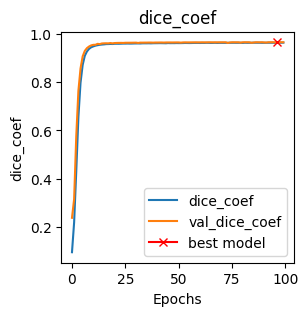

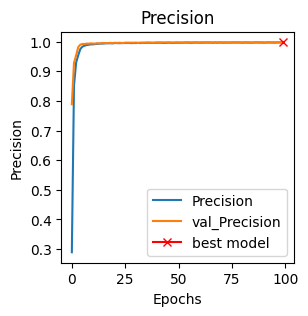

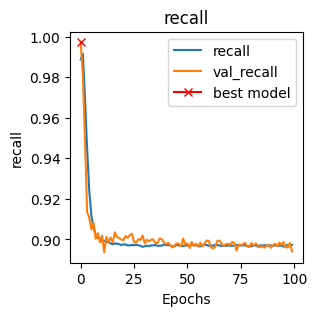

In [31]:
show_hist(model_history)

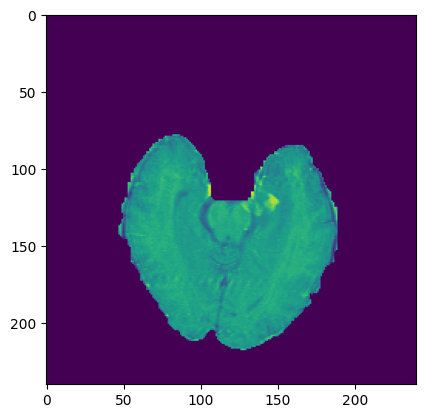

In [67]:
plt.imshow(images[val][1,:,:,0])
plt.show()

In [71]:
img_t = images[val][0:8]
wmp_t = weight_boundary[val][0:8]
val_t = masks[val][0:8]

In [56]:
img_t.shape

(8, 240, 240, 1)

In [57]:
a = concatenate([img_t,wmp_t],axis=-1)

In [58]:
a.shape

(8, 240, 240, 2)

In [59]:
p_maks = model.predict(a)

1/1 [==============================] - 0s 341ms/step


In [75]:
tf.saved_model.save(model, '/home/k8s-group5')

INFO:tensorflow:Assets written to: /home/k8s-group5/assets


INFO:tensorflow:Assets written to: /home/k8s-group5/assets
